In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from lib.ekyn import *
from lib.env import *
import copy
from sage.utils import *

MODEL_ID = f'2024_22_08_17_10_52'

state = torch.load(f'{EXPERIMENTS_PATH}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
model = copy.deepcopy(state['model'])
model.load_state_dict(state['best_model_wts'])
trainloader,testloader = get_epoched_dataloaders_loo(batch_size=state['batch_size'],robust=state['robust'],fold=state['fold'])
loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')

['A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1'] ['A1-0']
train_ids ['A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1']
test_ids ['A1-0']
507 training batches 34 testing batches
259584 training samples 17408 testing samples
721.07 training hours 48.36 testing hours


Text(0.5, 1.0, 'f1 : 0.863')

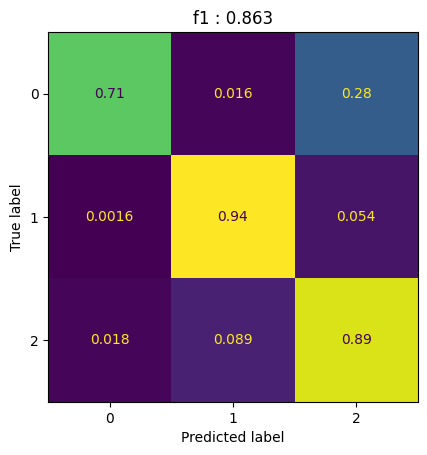

In [10]:
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False)
plt.title(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}')